#Example calculation of the ground state of Bose-Hubbard model




In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# including necessary files and latex fonts
!cp drive/MyDrive/DNN/HubbardNet_gpu.py .
!cp drive/MyDrive/DNN/matrix_element.py .
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install matplotlib==3.2.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

In [4]:
import time 
import torch
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import numpy as np
from HubbardNet_gpu import *
import matrix_element as me

from os import path
import os
from copy import copy


In [5]:
# Go to Edit -> Notebook Settings and select "GPU" from the hardware accelerator dropdown. 
# If this is on, GPU is enabled by default

use_gpu = True

# Check to see if gpu is available. If it is, use it else use the cpu
if torch.cuda.is_available() and use_gpu:
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print('Using GPU.')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.DoubleTensor')

    if not torch.cuda.is_available() and use_gpu: 
        use_gpu = False 
        print('GPU not available. Using CPU.')
    else: 
        print('Using CPU.')


Using GPU.


In [6]:
N_list = [4,5]
N = N_list[0]
model_list = []

M = 5
w = M
h = int(M/w)
pbc = True

for (n_idx, N) in enumerate(N_list): 
    O = N
    
    model = me.Bose_Hubbard(N, O, w=w, h=h, M=M, pbc=pbc)
    model_list.append(model)
    
    print("The size of the Hamiltonian is {}".format(model.tot_states))

t = 1 
U_max = 5
V = 0
U_list_all = np.arange(1, U_max+1, .5)
mu_list_all = np.linspace(0, 10, 5)
mu_list_all = np.array([0.])


The size of the Hamiltonian is 70
The size of the Hamiltonian is 126


In [7]:
from tqdm import tqdm

## NN

S = 50 # number of sample of the MH sampler (not used)
init = 1 # the first state to sample in Metropolis Hastings (has nothing to do with the optimizer!) (not used)

# Network parameters
D_hid = 400 # the number ofneurons in the hidden layer
lr = 0.01 # learning rate 
epochs = 70000
loss_diff = 1e-8
grad_cut = 1e-7
check_point = 100 # print out the energy every X points
use_sampler = False # for now, only support ground state (not working anyway)

# Model parameters
U_train = np.ones(3)*2
t_train = 1.

U_train = np.array([2., 3, 4])
mu_train = np.zeros_like(U_train)

min_state = 0
max_state = 1

n_excited = max_state - 1

# paths to save and load weights 
fpath = '/content/drive/MyDrive/DNN/weights_L2_1e-4_400_Uperturb_0.01/'

t0 = time.time()

loss_all = [] 
penalty_all = []
nn = []

# filepath for excited states
fname = fpath + "/weights_M{}N{}_V{}_Umax{}_Umin{}_L5_D{}".format(M,N,V,np.max(U_train),np.min(U_train),D_hid)


In [8]:
def call_NN(lr, n_excited):
  if n_excited: 
      if n_excited == 1 :
          load_states_indv = [0]
      else:
          load_states_indv = range(1, n_excited)
      gs_flag = False
      es_flag = True
        
  else: # ground states
      load_states_indv = [0]
      gs_flag = True
      es_flag = False
    
  load_states = np.max(load_states_indv)  # total number of states being fixed


  params = {'D_hid': D_hid, 
          'step_size': lr, 
          'max_iteration':epochs,
          'check_point': check_point,
          'loss_diff': loss_diff, 
          'steps': 1000, # reset learning every N steps
          'loss_check_steps': 100, # check the local every N steps
          "grad_cut": grad_cut,  # stopping condition in the total gradient 
          "weight_init": False, 
          "zero_bias": False, 
          "gs_epochs": 1000, # the maximum number of steps to minimize the ground state
          "gs_flag": gs_flag, # ground state only
          "es_flag": es_flag,  # excited state only
          "regularization": True, 
          "load_states": load_states, # the number of states loaded 
          "load_states_indv": load_states_indv, 
          "rand_steps": 5000, # randomize the projection every N steps
          "load_weights_from_previous_state": False, 
          "weight_decay": 0, 
          "perturb_amp": 0.0,
          "dropout": 0,
          "use_gpu": use_gpu
          }
  
  print("Begin optimizing for state {}".format(n_excited))
  
  fc1, Loss_history, dot_history, all_E_list = train_NN(model_list, N_list, mu_train, U_train, t_train, V, S, params, fname, \
                                            use_sampler=use_sampler, init=init, loadweights=False,\
                                            fname_load=fname, n_excited=n_excited)
                                            
    
  return fc1, Loss_history, dot_history



for n_excited in range(min_state, max_state):
    
    fc1, Loss_history, dot_history = call_NN(lr, n_excited)

    nn.append(fc1)
    loss_all.append(Loss_history)
    penalty_all.append(dot_history)
    
tf = time.time()
print("Training time = {} seconds.".format(tf-t0))

Begin optimizing for state 0
0.0


/content/HubbardNet_gpu.py:727: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  H_list.append(torch.tensor(H, dtype=torch.double))
/content/HubbardNet_gpu.py:416: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  all_states = torch.tensor([model_list[k].all_states[i].reshape((1,-1))
/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Iteration 0, current learning rate 0.01, loss -0.33536165952682495, total gradient 0.018238153052220984
Iteration 100, current learning rate 0.00975045441899919, loss -5.6956939697265625, total gradient -0.006020429919674948
Iteration 200, current learning rate 0.0090358814139336, loss -5.714478969573975, total gradient 0.020423541567379848
Iteration 300, current learning rate 0.007926253039256266, loss -5.719651699066162, total gradient 0.019875735898359108
Iteration 400, current learning rate 0.006530187446508231, loss -5.721578598022461, total gradient 0.017462546070863155
Iteration 500, current learning rate 0.004984341255885153, loss -5.722426891326904, total gradient 0.014379009619845234
Iteration 600, current learning rate 0.0034400326517927465, loss -5.722841262817383, total gradient 0.012240931007708351
Iteration 700, current learning rate 0.002048429298162418, loss -5.723049163818359, total gradient 0.01101497754482628
Iteration 800, current learning rate 0.000945750969609027

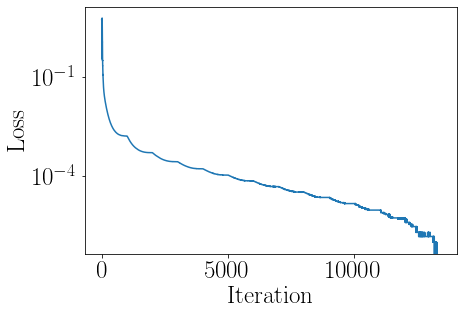

In [22]:
plt.rcParams.update({'font.size': 20})
plt.rc('text',usetex=True)
#font = {'family':'serif','size':16}
font = {'family':'serif','size':25, 'serif': ['computer modern roman']}
plt.rc('font',**font)
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
rc('text', usetex=True)
for i in range(1): 
    Loss_history = loss_all[i]
    Loss_history = np.array(Loss_history)
    
    fig,ax=plt.subplots(figsize=(7,5))
    ax.plot(Loss_history - np.min(Loss_history), '-', label='loss')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    # ax.set_title("U/t = {}".format(U_train))
    ax.set_yscale('log')
    
    
    # ax.plot(dot_history, '-', label='regularization')
    ax.set_xlabel("Iteration")
    # ax.set_ylabel("Dot product")
    # ax.set_title("U/t = {}".format(U_train))
    # ax.legend()
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/DNN/figures/loss_M{}N{}n{}.pdf'.format(M,N,range(min_state, max_state)[i]), format='pdf',bbox_inches='tight')
    plt.show()
    

In [10]:
E_all = np.zeros(( len(U_train), model.tot_states) )
# check solution 
for (i, U) in enumerate(U_train):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[i])
    evals, evecs = np.linalg.eig(H)
    idx = np.argsort(evals)
    evecs = evecs[:,idx]
    evals = evals[idx]
    E_all[i] = evals

<ipython-input-10-ce8b16fb9a7f>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  E_all[i] = evals


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


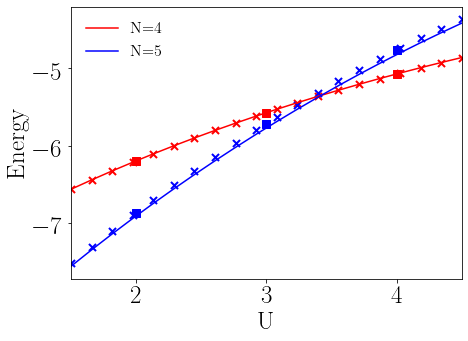

In [11]:
U_test = np.linspace(1.5, 4.5, 20)
mu_test = np.zeros_like(U_test)

plt.rcParams.update({'font.size': 20})
plt.rc('text',usetex=True)
#font = {'family':'serif','size':16}
font = {'family':'serif','size':25, 'serif': ['computer modern roman']}
plt.rc('font',**font)
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']

fig, ax = plt.subplots(figsize=(7,5))

colors = ['r','b']
for j,model in enumerate(model_list):
    E_train, wf_gs = wf_e_calc(model_list[j], N_list[0], U_train, mu_train, t, V, 0, 0, fc1, use_gpu=True)
    E_test, wf_gs_test = wf_e_calc(model_list[j], N_list[0], U_test, mu_test, t, V, 0, 0, fc1, use_gpu=True)

    
    ax.scatter(U_train,E_train,s=50,c=colors[j], marker='s')
    ax.scatter(U_test,E_test,s=50, c=colors[j], marker='x',lw=2)

    arr = [] 
    for (i, U) in enumerate(U_test):
        _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[0])
        vals, vecs = np.linalg.eig(H)
        vals_idx = np.argsort(vals)
        vals = np.sort(vals)
        arr.append(vals[0])
    ax.plot(U_test,arr,colors[j],label='N={}'.format(N_list[j]))
ax.set_xlim([min(U_test), max(U_test)])  
ax.set_ylabel('Energy')
ax.set_xlabel('U')
plt.legend(frameon=False,prop={'size': 16})
plt.savefig("/content/drive/MyDrive/DNN/figures/energy_M{}N{}.pdf".format(M,N), format='pdf',bbox_inches='tight')
plt.show()



<ipython-input-18-deaca3372d9a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  vals_all[:,0] = vals
<ipython-input-18-deaca3372d9a>:32: ComplexWarning: Casting complex values to real discards the imaginary part
  vecs_all[:,:,0] = vecs
<ipython-input-18-deaca3372d9a>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  vals_all[:,0] = vals
<ipython-input-18-deaca3372d9a>:32: ComplexWarning: Casting complex values to real discards the imaginary part
  vecs_all[:,:,0] = vecs


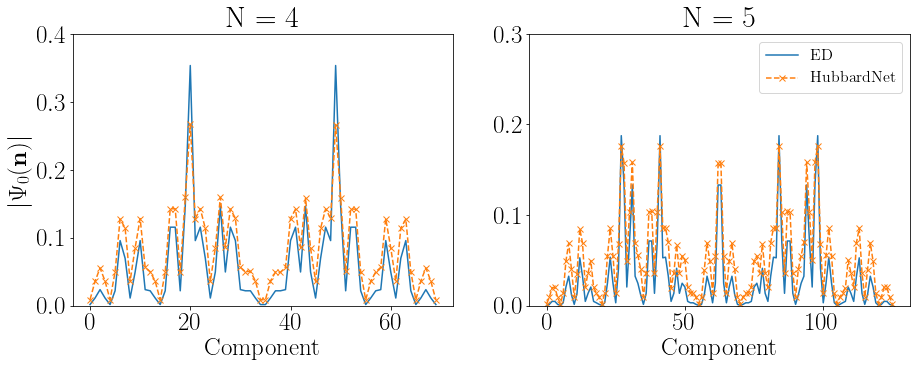

In [18]:
n_list = np.zeros( (len(model_list),M) )

fig, ax = plt.subplots(1, len(model_list), figsize=(15, 5))
U_test = np.array( [1.5] ) 

for model_idx,model in enumerate(model_list):
    # rearrange states by symmetry 
    all_states = np.zeros_like(model.all_states)
    idx_list = np.zeros(model.tot_states,dtype=int)

    for i in range(int(model.tot_states/2)): 
      all_states[i] = model.all_states[i]
      all_states[-i-1] = np.flip(model.all_states[i])
      idx_list[i] = i
      for j in range(model.tot_states):
        if all(model.all_states[j]==all_states[-i-1]): 
          idx_list[-i-1] = j
          break

    # check wavefunctions 
    
    mu_test = np.zeros(len(U_test))
    vals_all = np.zeros((model.tot_states, len(U_test)))
    vals_idx_all = np.zeros_like(vals_all)
    vecs_all = np.zeros((model.tot_states, model.tot_states, len(U_test)))

    
    _, _, H = model.H_Bose_Hubbard(t, U, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx_all[:,0] = np.argsort(vals)
    vals_all[:,0] = vals
    vecs_all[:,:,0] = vecs

    E_test, wf_test = wf_e_calc(model, N_list[model_idx], U_test, mu_test, t, V, 0, 0, fc1, use_gpu=True)
    
    s = 0 
    if model_idx == 0:
      ymax = 0.4
    else: 
      ymax = 0.3
    ymin = 0
  
    i=0
    wf_here = wf_test[i*model.tot_states:(i+1)*model.tot_states,s].squeeze().double()

    # calculate occupation numbers
    for m_idx in range(M):
        for state_idx in range(model.tot_states):
            ci = wf_here[state_idx].cpu().detach().numpy()
            ni = model.all_states[state_idx][m_idx]
            n_list[model_idx,m_idx] += ci**2 * ni

    wf_exact = np.abs(vecs_all[:,int(vals_idx_all[s, i]), i]).squeeze()
    wf_nn = np.abs(wf_here.cpu().detach().numpy())
    ax[model_idx].plot(wf_exact[idx_list], label="ED")
    ax[model_idx].plot(wf_nn[idx_list], 'x--', label="HubbardNet")
    
    ax[model_idx].set_title("N = {}".format(N_list[model_idx]))
    ax[model_idx].set_ylim((ymin,ymax))

ax[0].set_ylabel('$|\Psi_0 (\mathbf{n})|$')
ax[0].set_xlabel('Component')
ax[1].set_xlabel('Component')
ax[1].legend(frameon=True, prop={'size': 16})
plt.savefig("/content/drive/MyDrive/DNN/figures/wf_multi_N_M{}_gs.pdf".format(M,N_list[model_idx],s,n_excited), format='pdf',bbox_inches='tight')
plt.show()





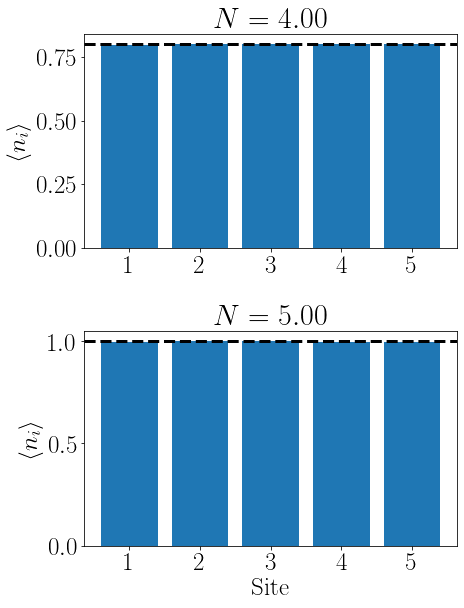

In [23]:
xgrid, ygrid = np.meshgrid(np.arange(w)+1, np.arange(h)+1)
xgrid = xgrid.ravel()
ygrid = ygrid.ravel()

if h == 1: # 1D
    fig, ax = plt.subplots(len(model_list),1,figsize=(7,9))
    for i in range(len(model_list)): 
      ax[i].bar(xgrid,n_list[i,:])
      ax[i].set_title("$N = {0:.2f}$".format(N_list[i]))
      ax[i].set_xticks(xgrid)
      ax[i].axhline( N_list[i]/M, linewidth=3, color='k', linestyle='--')
      ax[i].set_ylabel(r'$ \langle n_i \rangle $')
    ax[i].set_xlabel('Site')
   
  

else: # 2D 
    idx=2
    fig, ax = plt.subplots(figsize=(7,7))
    im=plt.pcolormesh(np.reshape(n_list[idx,:],(h,w)),cmap='coolwarm')
    ax.grid(True, color="k", lw=1)
    cbar=plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.set_label(r'$\langle n_i \rangle$')
    ax.set_aspect('equal')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xticks(np.arange(w))
    plt.yticks(np.arange(h))
    plt.title('$U = {}$'.format(U_test[idx]))
    
plt.tight_layout()      
plt.savefig("/content/drive/MyDrive/DNN/figures/occupation_M{}N{}U{}.pdf".format(M,N,U), format='pdf',bbox_inches='tight')
plt.show()
